# Setup dependencies

In [1]:
import numpy as np
import pandas as pd
import icecream as ic
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, JaccardIndex, MetricCollection
from torchinfo import summary

from floortrans.loaders import FloorplanSVG
from floortrans.loaders.augmentations import Compose, ResizePaddedTorch, DictToTensor

from model.deeplabv3plus import DeepLabV3Plus

import pingouin as pg

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear GPU cache to avoid memory errors
torch.cuda.empty_cache()

# Set seed and deterministic behavior to ensure reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('Device:', device)
print('Setup completed')

Device: cuda
Setup completed


# Load test dataset

In [2]:
img_shape = (256, 256)

aug = Compose([
    ResizePaddedTorch((0, 0), data_format='dict', size=img_shape), 
    DictToTensor()
])

test_dataset = FloorplanSVG('data/cubicasa5k/', 'test.txt', format='lmdb', augmentations=aug)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f'Test dataset size: {len(test_dataset)}')
print(f'Test images shape: {test_dataset[0]["image"].shape}')
print(f'Test labels shape: {test_dataset[0]["label"].shape}')

Test dataset size: 400
Test images shape: torch.Size([3, 256, 256])
Test labels shape: torch.Size([23, 256, 256])


# Setup models

In [3]:
deeplab_base_path = 'best_models/deeplab_efficientnet_b2_base.pt'

deeplab_base = DeepLabV3Plus(backbone='efficientnet_b2', attention=False)
deeplab_base.load_state_dict(torch.load(deeplab_base_path)['model_state_dict'])
deeplab_base.to(device)

summary(deeplab_base, input_size=(1, 3, img_shape[0], img_shape[1]))

C:\Users\Red\AppData\Local\Temp\ipykernel_8308\2671476482.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab_base.load_state_dict(torch.load(deeplab_base_path)['mod

Layer (type:depth-idx)                                            Output Shape              Param #
DeepLabV3Plus                                                     [1, 12, 256, 256]         --
├─Backbone: 1-1                                                   [1, 24, 64, 64]           --
│    └─EfficientNet: 2-1                                          --                        1,409,000
│    │    └─Sequential: 3-1                                       --                        7,700,994
├─ASPP: 1-2                                                       [1, 256, 8, 8]            --
│    └─Conv2d: 2-2                                                [1, 256, 8, 8]            360,448
│    └─AtrousConv: 2-3                                            [1, 256, 8, 8]            --
│    │    └─DepthwiseSeparableConv: 3-2                           [1, 256, 8, 8]            373,632
│    └─AtrousConv: 2-4                                            [1, 256, 8, 8]            --
│    │    └─Depthwise

In [4]:
deeplab_casa_path = 'best_models/deeplab_efficientnet_b2_ca_sa.pt'

deeplab_casa = DeepLabV3Plus(backbone='efficientnet_b2', attention=True)
deeplab_casa.load_state_dict(torch.load(deeplab_casa_path)['model_state_dict'])
deeplab_casa.to(device)

summary(deeplab_casa, input_size=(1, 3, img_shape[0], img_shape[1]))

C:\Users\Red\AppData\Local\Temp\ipykernel_8308\4258419339.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplab_casa.load_state_dict(torch.load(deeplab_casa_path)['mod

Layer (type:depth-idx)                                            Output Shape              Param #
DeepLabV3Plus                                                     [1, 12, 256, 256]         --
├─Backbone: 1-1                                                   [1, 24, 64, 64]           --
│    └─EfficientNet: 2-1                                          --                        1,409,000
│    │    └─Sequential: 3-1                                       --                        7,700,994
├─ASPP: 1-2                                                       [1, 256, 8, 8]            --
│    └─Conv2d: 2-2                                                [1, 256, 8, 8]            360,448
│    └─AtrousConv: 2-3                                            [1, 256, 8, 8]            --
│    │    └─DepthwiseSeparableConv: 3-2                           [1, 256, 8, 8]            373,632
│    │    └─ChannelAttention: 3-3                                 [1, 256, 8, 8]            8,464
│    └─AtrousConv:

# Evaluate models on test set

In [5]:
def compute_combined_metrics(room_class_metrics, icon_class_metrics, combined_class_freq):
    combined_acc = torch.cat([room_class_metrics['acc'].compute(), icon_class_metrics['acc'].compute()])
    combined_iou = torch.cat([room_class_metrics['iou'].compute(), icon_class_metrics['iou'].compute()])

    combined_mpa = combined_acc.mean()
    combined_miou = combined_iou.mean()

    # fwiou
    total_pixels = combined_class_freq.sum()
    combined_fwiou = (combined_class_freq / total_pixels * combined_iou).sum()

    return {
        'mpa': combined_mpa.item(),
        'cpa': combined_acc.tolist(),
        'miou': combined_miou.item(),
        'fwiou': combined_fwiou.item()
    }


def evaluate(model, model_name, loader, device):
    model.eval()

    # Evaluation metrics 
    room_mpa = Accuracy(task='multiclass', num_classes=12, average='macro').to(device)
    room_cpa = Accuracy(task='multiclass', num_classes=12, average='none').to(device)
    room_miou = JaccardIndex(task='multiclass', num_classes=12, average='macro').to(device)
    room_fwiou = JaccardIndex(task='multiclass', num_classes=12, average='weighted').to(device)

    icon_mpa = Accuracy(task='multiclass', num_classes=11, average='macro').to(device)
    icon_cpa = Accuracy(task='multiclass', num_classes=11, average='none').to(device)
    icon_miou = JaccardIndex(task='multiclass', num_classes=11, average='macro').to(device)
    icon_fwiou = JaccardIndex(task='multiclass', num_classes=11, average='weighted').to(device)

    # For computing combined metrics
    room_class_metrics = MetricCollection({
        'acc': Accuracy(task='multiclass', num_classes=12, average=None),
        'iou': JaccardIndex(task='multiclass', num_classes=12, average=None)     
    }).to(device)

    icon_class_metrics = MetricCollection({
        'acc': Accuracy(task='multiclass', num_classes=11, average=None),
        'iou': JaccardIndex(task='multiclass', num_classes=11, average=None)     
    }).to(device)

    # To compute combined fwiou
    combined_class_freq = torch.zeros(23).to(device)
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f'Evaluating {model_name}', unit='samples'):
            # Extract input images and labels
            images = batch['image'].float().to(device)
            room_labels = batch['label'][:, 21].long().to(device)
            icon_labels = batch['label'][:, 22].long().to(device)

            # Get raw outputs (omitted heatmap output)
            room_logits, icon_logits, _ = model(images)

            # Get predictions
            room_preds = room_logits.argmax(dim=1)
            icon_preds = icon_logits.argmax(dim=1)

            # Update metrics
            room_mpa(room_preds, room_labels)
            room_cpa(room_preds, room_labels)
            room_miou(room_preds, room_labels)
            room_fwiou(room_preds, room_labels)
            icon_mpa(icon_preds, icon_labels)
            icon_cpa(icon_preds, icon_labels)
            icon_miou(icon_preds, icon_labels)
            icon_fwiou(icon_preds, icon_labels)

            room_class_metrics(room_preds, room_labels)
            icon_class_metrics(icon_preds, icon_labels)

            # Update combined class frequency
            combined_class_freq[:12] += torch.bincount(room_labels.flatten(), minlength=12)
            combined_class_freq[12:] += torch.bincount(icon_labels.flatten(), minlength=11)

    # Get actual metric values
    room_mpa_val = room_mpa.compute().item()
    room_miou_val = room_miou.compute().item()
    room_fwiou_val = room_fwiou.compute().item()

    icon_mpa_val = icon_mpa.compute().item()
    icon_miou_val = icon_miou.compute().item()
    icon_fwiou_val = icon_fwiou.compute().item()
    
    room_cpa_list = [val for val in room_cpa.compute().tolist()]
    icon_cpa_list = [val for val in icon_cpa.compute().tolist()]

    # Compute combined metrics
    combined_metrics = compute_combined_metrics(room_class_metrics, icon_class_metrics, combined_class_freq)
    combined_mpa = combined_metrics['mpa']
    combined_miou = combined_metrics['miou']
    combined_fwiou = combined_metrics['fwiou']
    combined_cpa = [val for val in combined_metrics['cpa']]

    return {
        'room_mpa': room_mpa_val,
        'room_cpa': room_cpa_list,
        'room_miou': room_miou_val,
        'room_fwiou': room_fwiou_val,
        'icon_mpa': icon_mpa_val,
        'icon_cpa': icon_cpa_list,
        'icon_miou': icon_miou_val,
        'icon_fwiou': icon_fwiou_val,
        'combined_mpa': combined_mpa,
        'combined_cpa': combined_cpa,
        'combined_miou': combined_miou,
        'combined_fwiou': combined_fwiou
    }

# Run evaluation
deeplab_base_results = evaluate(deeplab_base, 'DeepLabV3+ Base', test_loader, device)
deeplab_casa_results = evaluate(deeplab_casa, 'DeepLabV3+ CA & SA', test_loader, device)

Evaluating DeepLabV3+ CA & SA: 100%|██████████| 400/400 [00:59<00:00,  6.69samples/s]


In [6]:
results_dict = {
    'Model': ['Base DeepLabV3+', 'DeepLabV3+ w/ CA & SA'],
    'Room MPA': [deeplab_base_results['room_mpa'], deeplab_casa_results['room_mpa']],
    'Room mIoU': [deeplab_base_results['room_miou'], deeplab_casa_results['room_miou']],
    'Room fWIoU': [deeplab_base_results['room_fwiou'], deeplab_casa_results['room_fwiou']],
    'Icon MPA': [deeplab_base_results['icon_mpa'], deeplab_casa_results['icon_mpa']],
    'Icon mIoU': [deeplab_base_results['icon_miou'], deeplab_casa_results['icon_miou']],
    'Icon fWIoU': [deeplab_base_results['icon_fwiou'], deeplab_casa_results['icon_fwiou']],
    'Combined MPA': [deeplab_base_results['combined_mpa'], deeplab_casa_results['combined_mpa']],
    'Combined mIoU': [deeplab_base_results['combined_miou'], deeplab_casa_results['combined_miou']],
    'Combined fWIoU': [deeplab_base_results['combined_fwiou'], deeplab_casa_results['combined_fwiou']]
}

results_df = pd.DataFrame(results_dict)
results_df

,Model,Room MPA,Room mIoU,Room fWIoU,Icon MPA,Icon mIoU,Icon fWIoU,Combined MPA,Combined mIoU,Combined fWIoU
0,Base DeepLabV3+,0.565069,0.422805,0.717486,0.385256,0.277856,0.926109,0.479071,0.353482,0.821797
1,DeepLabV3+ w/ CA & SA,0.558720,0.414512,0.712427,0.385995,0.275620,0.925375,0.476113,0.348085,0.818901


In [7]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room", "Bedroom", "Bath", "Hallway", "Railing", "Storage", "Garage", "Other rooms"]
icon_classes = ["Empty", "Window", "Door", "Closet", "Electr. Appl.", "Toilet", "Sink", "Sauna bench", "Fire Place", "Bathtub", "Chimney"]
combined_classes = room_classes + icon_classes

room_class_acc = { room_classes[i]: [deeplab_base_results['room_cpa'][i], deeplab_casa_results['room_cpa'][i]] for i in range(len(room_classes)) }
icon_class_acc = { icon_classes[i]: [deeplab_base_results['icon_cpa'][i], deeplab_casa_results['icon_cpa'][i]] for i in range(len(icon_classes)) }
combined_class_acc = { combined_classes[i]: [deeplab_base_results['combined_cpa'][i], deeplab_casa_results['combined_cpa'][i]] for i in range(len(combined_classes)) }

room_class_acc_df = pd.DataFrame(room_class_acc, index=['DeepLabV3+ Base', 'DeepLabV3+ CA & SA'])
icon_class_acc_df = pd.DataFrame(icon_class_acc, index=['DeepLabV3+ Base', 'DeepLabV3+ CA & SA'])
combined_class_acc_df = pd.DataFrame(combined_class_acc, index=['DeepLabV3+ Base', 'DeepLabV3+ CA & SA'])

In [8]:
room_class_acc_df

,Background,Outdoor,Wall,Kitchen,Living Room,Bedroom,Bath,Hallway,Railing,Storage,Garage,Other rooms
DeepLabV3+ Base,0.957633,0.671911,0.683476,0.700767,0.731366,0.727061,0.625376,0.630002,0.343768,0.319615,0.0,0.389849
DeepLabV3+ CA & SA,0.954867,0.695179,0.687271,0.679967,0.713794,0.685421,0.619945,0.605573,0.340725,0.344425,0.0,0.377474


In [9]:
icon_class_acc_df

,Empty,Window,Door,Closet,Electr. Appl.,Toilet,Sink,Sauna bench,Fire Place,Bathtub,Chimney
DeepLabV3+ Base,0.976381,0.547589,0.435732,0.562821,0.499441,0.321224,0.347012,0.547620,0.0,0.0,0.0
DeepLabV3+ CA & SA,0.975541,0.552423,0.446046,0.562097,0.496312,0.338278,0.342278,0.532972,0.0,0.0,0.0


# Research Question 1
What is the level of accuracy of the modified DeepLabv3+ with CA and SA modules for segmenting both core floor plan objects and furniture in terms of:
- Class Pixel Accuracy (Class Acc)
- Overall Pixel Accuracy (Acc.)
- Mean Intersection over Union (mIoU)
- Frequency Weighted Intersection over Union (fwIoU)

In [10]:
sop1_agg_results = pd.DataFrame({
    'Model': ['Base DeepLabV3+', 'DeepLabV3+ w/ CA & SA'],
    'mPA': [deeplab_base_results['combined_mpa'], deeplab_casa_results['combined_mpa']],
    'mIoU': [deeplab_base_results['combined_miou'], deeplab_casa_results['combined_miou']],
    'fWIoU': [deeplab_base_results['combined_fwiou'], deeplab_casa_results['combined_fwiou']]
})

sop1_agg_results

,Model,mPA,mIoU,fWIoU
0,Base DeepLabV3+,0.479071,0.353482,0.821797
1,DeepLabV3+ w/ CA & SA,0.476113,0.348085,0.818901


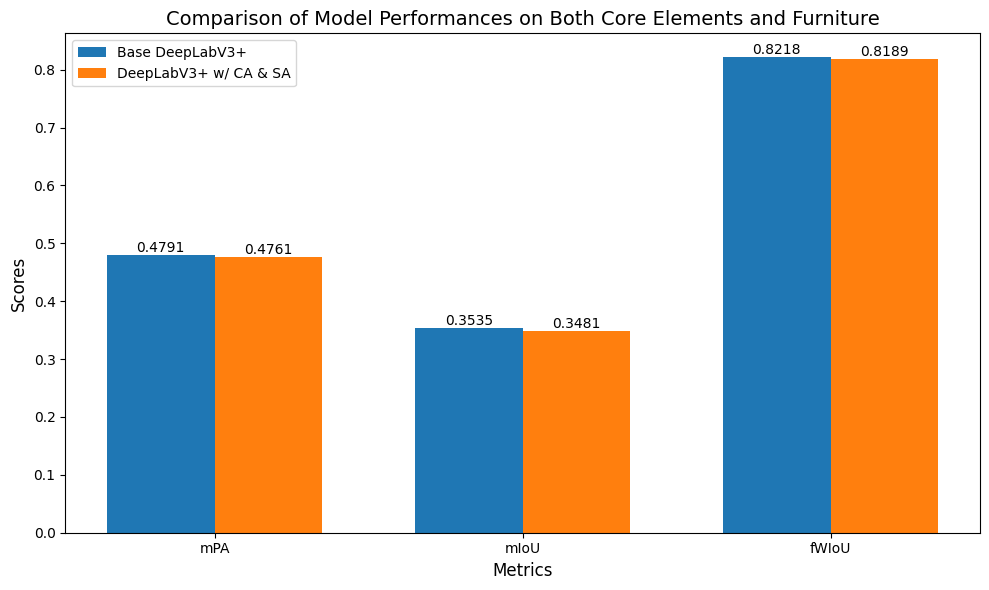

In [11]:
metrics = ['mPA', 'mIoU', 'fWIoU']
models = sop1_agg_results['Model']
x = np.arange(len(metrics))  # Number of metrics
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
for i, model in enumerate(models):
    values = sop1_agg_results.iloc[i, 1:]
    bars = ax.bar(x + i * width, values, width, label=model)
    # Add text annotations above bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                ha='center', va='bottom', fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performances on Both Core Elements and Furniture', fontsize=14)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
sop1_class_results = pd.DataFrame({
    'Class': combined_classes,
    'DeepLabV3+ Base': deeplab_base_results['combined_cpa'],
    'DeepLabV3+ CA & SA': deeplab_casa_results['combined_cpa']
})

sop1_class_results

,Class,DeepLabV3+ Base,DeepLabV3+ CA & SA
0,Background,0.957633,0.954867
1,Outdoor,0.671911,0.695179
2,Wall,0.683476,0.687271
3,Kitchen,0.700767,0.679967
4,Living Room,0.731366,0.713794
5,Bedroom,0.727061,0.685421
6,Bath,0.625376,0.619945
7,Hallway,0.630002,0.605573
8,Railing,0.343768,0.340725
9,Storage,0.319615,0.344425


# Research Question 2
What is the level of accuracy of the modified DeepLabv3+ with CA and SA modules for segmenting only core floor plan objects in terms of:
- Class Pixel Accuracy (Class Acc)
- Overall Pixel Accuracy (Acc.)
- Mean Intersection over Union (mIoU)
- Frequency Weighted Intersection over Union (fwIoU)

In [13]:
sop2_agg_results = pd.DataFrame({
    'Model': ['Base DeepLabV3+', 'DeepLabV3+ w/ CA & SA'],
    'mPA': [deeplab_base_results['room_mpa'], deeplab_casa_results['room_mpa']],
    'mIoU': [deeplab_base_results['room_miou'], deeplab_casa_results['room_miou']],
    'fWIoU': [deeplab_base_results['room_fwiou'], deeplab_casa_results['room_fwiou']]
})

sop2_agg_results

,Model,mPA,mIoU,fWIoU
0,Base DeepLabV3+,0.565069,0.422805,0.717486
1,DeepLabV3+ w/ CA & SA,0.558720,0.414512,0.712427


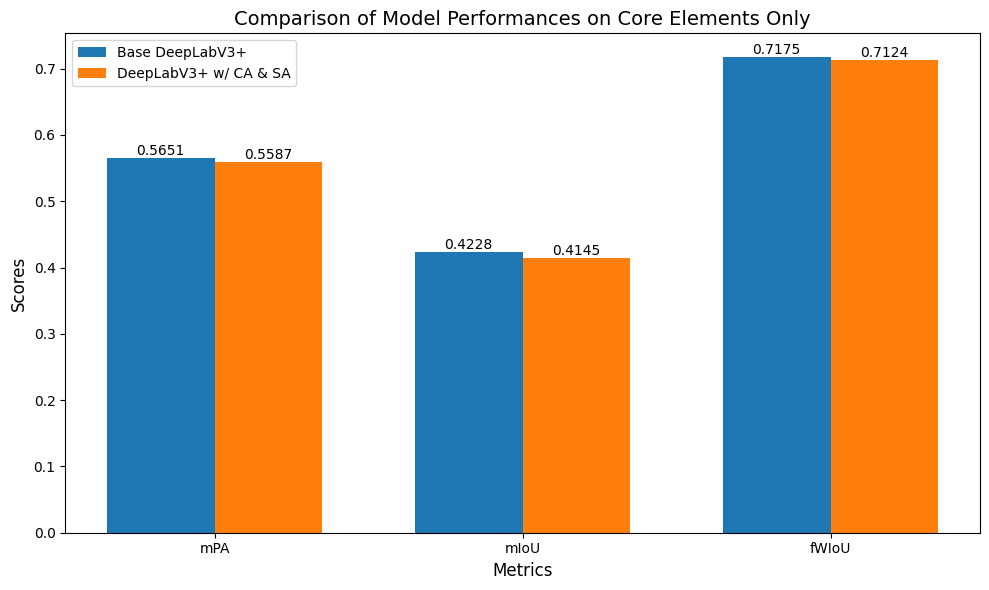

In [14]:
metrics = ['mPA', 'mIoU', 'fWIoU']
models = sop2_agg_results['Model']
x = np.arange(len(metrics))  # Number of metrics
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
for i, model in enumerate(models):
    values = sop2_agg_results.iloc[i, 1:]
    bars = ax.bar(x + i * width, values, width, label=model)
    # Add text annotations above bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                ha='center', va='bottom', fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performances on Core Elements Only', fontsize=14)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
sop2_class_results = pd.DataFrame({
    'Class': room_classes,
    'DeepLabV3+ Base': deeplab_base_results['room_cpa'],
    'DeepLabV3+ w/ CA & SA': deeplab_casa_results['room_cpa']
})

sop2_class_results

,Class,DeepLabV3+ Base,DeepLabV3+ w/ CA & SA
0,Background,0.957633,0.954867
1,Outdoor,0.671911,0.695179
2,Wall,0.683476,0.687271
3,Kitchen,0.700767,0.679967
4,Living Room,0.731366,0.713794
5,Bedroom,0.727061,0.685421
6,Bath,0.625376,0.619945
7,Hallway,0.630002,0.605573
8,Railing,0.343768,0.340725
9,Storage,0.319615,0.344425


# Research Question 3
Is there a significant difference in the performance of the modified DeepLabv3+ with CA and SA modules compared to the unmodified base model in terms of:
- Overall Pixel Accuracy (Acc.)
- Mean Intersection over Union (mIoU)
- Frequency Weighted Intersection over Union (fwIoU)

### Compute per-image mPA, mIoU, and fwIoU

In [27]:
def get_img_dir():
    dataset = FloorplanSVG('data/cubicasa5k/', 'test.txt', format='lmdb')
    dirs = []

    for i in range(len(dataset)):
        dirs.append(f"cubicasa5k{dataset[i]['folder']}")
    
    return dirs


def evaluate_per_image(model, model_name, loader, device):
    # Store as tensors for efficient computation
    mpa = torch.tensor([]).to(device)
    miou= torch.tensor([]).to(device)
    fwiou = torch.tensor([]).to(device)

    # Use combined metrics for this
    room_class_metrics = MetricCollection({
        'acc': Accuracy(task='multiclass', num_classes=12, average=None),
        'iou': JaccardIndex(task='multiclass', num_classes=12, average=None)     
    }).to(device)

    icon_class_metrics = MetricCollection({
        'acc': Accuracy(task='multiclass', num_classes=11, average=None),
        'iou': JaccardIndex(task='multiclass', num_classes=11, average=None)     
    }).to(device)

    # To compute combined fwiou
    combined_class_freq = torch.zeros(23).to(device)

    with torch.no_grad():
        for batch in tqdm(loader, desc=f'Evaluating {model_name}', unit='samples'):
            # Extract input images and labels
            images = batch['image'].float().to(device)
            room_labels = batch['label'][:, 21].long().to(device)
            icon_labels = batch['label'][:, 22].long().to(device)

            # Get raw outputs (omitted heatmap output)
            room_logits, icon_logits, _ = model(images)

            # Get predictions
            room_preds = room_logits.argmax(dim=1)
            icon_preds = icon_logits.argmax(dim=1)

            # Update metrics
            room_class_metrics(room_preds, room_labels)
            icon_class_metrics(icon_preds, icon_labels)

            # Update combined class frequency
            combined_class_freq[:12] += torch.bincount(room_labels.flatten(), minlength=12)
            combined_class_freq[12:] += torch.bincount(icon_labels.flatten(), minlength=11)

            # Compute per image metrics
            room_acc = room_class_metrics['acc'].compute().cpu().numpy()
            icon_acc = icon_class_metrics['acc'].compute().cpu().numpy()
            room_iou = room_class_metrics['iou'].compute().cpu().numpy()
            icon_iou = icon_class_metrics['iou'].compute().cpu().numpy()

            combined_acc = torch.cat([torch.tensor(room_acc).to(device), torch.tensor(icon_acc).to(device)])
            combined_iou = torch.cat([torch.tensor(room_iou).to(device), torch.tensor(icon_iou).to(device)])

            mpa_img = combined_acc.mean().item()
            miou_img = combined_iou.mean().item()

            total_pixels = combined_class_freq.sum().item()
            fwiou_img = (combined_class_freq / total_pixels * combined_iou).sum().item()

            # Append to tensors
            mpa = torch.cat([mpa, torch.tensor([mpa_img]).to(device)])
            miou = torch.cat([miou, torch.tensor([miou_img]).to(device)])
            fwiou = torch.cat([fwiou, torch.tensor([fwiou_img]).to(device)])

    return pd.DataFrame({
        'directory': get_img_dir(),
        'model': model_name, 
        'mpa': mpa.tolist(), 
        'miou': miou.tolist(), 
        'fwiou': fwiou.tolist() 
    })


base_per_img_res = evaluate_per_image(deeplab_base, 'DeepLabV3+ Base', test_loader, device)
base_per_img_res

Evaluating DeepLabV3+ Base: 100%|██████████| 400/400 [00:47<00:00,  8.47samples/s]


,directory,model,mpa,miou,fwiou
0,cubicasa5k/high_quality_architectural/1191/,DeepLabV3+ Base,0.384218,0.275397,0.814589
1,cubicasa5k/high_quality_architectural/2536/,DeepLabV3+ Base,0.514677,0.403391,0.829363
2,cubicasa5k/high_quality_architectural/2530/,DeepLabV3+ Base,0.469312,0.370765,0.832951
3,cubicasa5k/high_quality_architectural/2504/,DeepLabV3+ Base,0.481727,0.371410,0.824772
4,cubicasa5k/high_quality_architectural/2207/,DeepLabV3+ Base,0.433784,0.325176,0.808431
...,...,...,...,...,...
395,cubicasa5k/high_quality_architectural/7715/,DeepLabV3+ Base,0.478674,0.352924,0.821330
396,cubicasa5k/high_quality_architectural/9384/,DeepLabV3+ Base,0.478558,0.352893,0.821369
397,cubicasa5k/high_quality_architectural/3024/,DeepLabV3+ Base,0.478805,0.353111,0.821552
398,cubicasa5k/high_quality_architectural/18/,DeepLabV3+ Base,0.479070,0.353364,0.821849


In [28]:
casa_per_img_res = evaluate_per_image(deeplab_casa, 'DeepLabV3+ CA & SA', test_loader, device)
casa_per_img_res

Evaluating DeepLabV3+ CA & SA: 100%|██████████| 400/400 [00:45<00:00,  8.73samples/s]


,directory,model,mpa,miou,fwiou
0,cubicasa5k/high_quality_architectural/1191/,DeepLabV3+ CA & SA,0.374592,0.256687,0.803479
1,cubicasa5k/high_quality_architectural/2536/,DeepLabV3+ CA & SA,0.374950,0.278450,0.746746
2,cubicasa5k/high_quality_architectural/2530/,DeepLabV3+ CA & SA,0.363881,0.270445,0.772010
3,cubicasa5k/high_quality_architectural/2504/,DeepLabV3+ CA & SA,0.414413,0.304522,0.786701
4,cubicasa5k/high_quality_architectural/2207/,DeepLabV3+ CA & SA,0.390422,0.279238,0.786886
...,...,...,...,...,...
395,cubicasa5k/high_quality_architectural/7715/,DeepLabV3+ CA & SA,0.475794,0.347541,0.818402
396,cubicasa5k/high_quality_architectural/9384/,DeepLabV3+ CA & SA,0.475632,0.347485,0.818438
397,cubicasa5k/high_quality_architectural/3024/,DeepLabV3+ CA & SA,0.475869,0.347706,0.818629
398,cubicasa5k/high_quality_architectural/18/,DeepLabV3+ CA & SA,0.476045,0.347894,0.818918


In [29]:
combined_per_img_res = pd.concat([base_per_img_res, casa_per_img_res], ignore_index=True)
combined_per_img_res

,directory,model,mpa,miou,fwiou
0,cubicasa5k/high_quality_architectural/1191/,DeepLabV3+ Base,0.384218,0.275397,0.814589
1,cubicasa5k/high_quality_architectural/2536/,DeepLabV3+ Base,0.514677,0.403391,0.829363
2,cubicasa5k/high_quality_architectural/2530/,DeepLabV3+ Base,0.469312,0.370765,0.832951
3,cubicasa5k/high_quality_architectural/2504/,DeepLabV3+ Base,0.481727,0.371410,0.824772
4,cubicasa5k/high_quality_architectural/2207/,DeepLabV3+ Base,0.433784,0.325176,0.808431
...,...,...,...,...,...
795,cubicasa5k/high_quality_architectural/7715/,DeepLabV3+ CA & SA,0.475794,0.347541,0.818402
796,cubicasa5k/high_quality_architectural/9384/,DeepLabV3+ CA & SA,0.475632,0.347485,0.818438
797,cubicasa5k/high_quality_architectural/3024/,DeepLabV3+ CA & SA,0.475869,0.347706,0.818629
798,cubicasa5k/high_quality_architectural/18/,DeepLabV3+ CA & SA,0.476045,0.347894,0.818918


### One-Way ANOVA Test

In [17]:
anova_mpa = pg.anova(data=combined_per_img_res, dv='mpa', between='model')
anova_mpa


,Source,ddof1,ddof2,F,p-unc,np2
0,model,1,798,34.429843,6.473988e-09,0.041361


In [18]:
# anova_mpa_posthoc = pg.pairwise_tukey(data=combined_per_img_res, dv='mpa', between='model')
# anova_mpa_posthoc

In [19]:
anova_miou = pg.anova(data=combined_per_img_res, dv='miou', between='model')
anova_miou

,Source,ddof1,ddof2,F,p-unc,np2
0,model,1,798,93.380812,5.755567e-21,0.10476


In [20]:
# anova_miou_posthoc = pg.pairwise_tukey(data=combined_per_img_res, dv='miou', between='model')
# anova_miou_posthoc

In [21]:
anova_fwiou = pg.anova(data=combined_per_img_res, dv='miou', between='model')
anova_fwiou

,Source,ddof1,ddof2,F,p-unc,np2
0,model,1,798,93.380812,5.755567e-21,0.10476


In [22]:
# anova_fwiou_posthoc = pg.pairwise_tukey(data=combined_per_img_res, dv='fwiou', between='model')
# anova_fwiou_posthoc

### Make Decision

In [23]:
a = 0.05
anova_combined = [anova_mpa, anova_miou, anova_fwiou]

sop3_dict = {
    'Metric': ['mPA', 'mIoU', 'fWIoU'],
    'F-value': [],
    'p-value': [],
    'p < 0.05': [],
    'Verdict': []
}

for i in range(3):
    sop3_dict['F-value'].append(anova_combined[i]['F'][0])
    sop3_dict['p-value'].append(anova_combined[i]['p-unc'][0])
    sop3_dict['p < 0.05'].append(anova_combined[i]['p-unc'][0] < a)
    sop3_dict['Verdict'].append('Reject H0' if anova_combined[i]['p-unc'][0] < a else 'Fail to reject H0')

sop3_results = pd.DataFrame(sop3_dict)
sop3_results

,Metric,F-value,p-value,p < 0.05,Verdict
0,mPA,34.429843,6.473988e-09,True,Reject H0
1,mIoU,93.380812,5.755567e-21,True,Reject H0
2,fWIoU,93.380812,5.755567e-21,True,Reject H0


### Paired T-Test (Experimental)

In [42]:
mpa_ttest = pg.ttest(x=casa_per_img_res['mpa'], y=base_per_img_res['mpa'], paired=True, alternative='greater')
miou_ttest = pg.ttest(x=casa_per_img_res['miou'], y=base_per_img_res['miou'], paired=True, alternative='greater')
fwiou_ttest = pg.ttest(x=casa_per_img_res['fwiou'], y=base_per_img_res['fwiou'], paired=True, alternative='greater')

ttest_combined = pd.concat([mpa_ttest, miou_ttest, fwiou_ttest], ignore_index=True)
print(ttest_combined)

alpha = 0.05
sop3_experimental_dict = {
    'Metric': ['mPA', 'mIoU', 'fWIoU'],
    't-value': [],
    'p-value': [],
    'p < 0.05': [],
    'Verdict': []
}

for i in range(3):
    sop3_experimental_dict['t-value'].append(ttest_combined['T'][i])
    sop3_experimental_dict['p-value'].append(ttest_combined['p-val'][i])
    sop3_experimental_dict['p < 0.05'].append(ttest_combined['p-val'][i] < alpha)
    sop3_experimental_dict['Verdict'].append('Reject H0' if ttest_combined['p-val'][i] < alpha else 'Fail to reject H0')

sop3_experimental_results = pd.DataFrame(sop3_experimental_dict)
sop3_experimental_results

           T  dof alternative  p-val         CI95%   cohen-d       BF10  power
0 -15.412848  399     greater    1.0  [-0.01, inf]  0.414909  5.172e-40    0.0
1 -21.721748  399     greater    1.0  [-0.01, inf]  0.683304  4.784e-67    0.0
2 -19.592852  399     greater    1.0  [-0.01, inf]  0.413881  7.362e-58    0.0


,Metric,t-value,p-value,p < 0.05,Verdict
0,mPA,-15.412848,1.0,False,Fail to reject H0
1,mIoU,-21.721748,1.0,False,Fail to reject H0
2,fWIoU,-19.592852,1.0,False,Fail to reject H0


# Save results as spreadsheet

In [24]:
with pd.ExcelWriter('test_results/experiments.xlsx') as writer:
    sop1_agg_results.to_excel(writer, sheet_name='sop1_aggregated')
    sop1_class_results.to_excel(writer, sheet_name='sop1_classwise')
    sop2_agg_results.to_excel(writer, sheet_name='sop2_aggregated')
    sop2_class_results.to_excel(writer, sheet_name='sop2_classwise')
    sop3_results.to_excel(writer, sheet_name='sop3')

print('Results saved to spreadsheet')

Results saved to spreadsheet


In [26]:
with pd.ExcelWriter('test_results/per_image_metrics.xlsx') as writer:
    combined_per_img_res.to_excel(writer, sheet_name='per_image_metrics')

print('Per-image metrics saved to spreadsheet')

Per-image metrics saved to spreadsheet
